First we'll define the alexnet class

In [1]:
import tensorflow as tf
import numpy as np
from caffe_classes import class_names
import datagenerator
import alexnet

In [44]:
# Class is already in alexnet.py ..copied here also to look up [Don't load it multiple times..]
class AlexNet(object):
    def __init__(self,x,keep_prob,num_classes,skip_layer,weights_path='DEFAULT'):
        self.X=x
        self.NUM_CLASSES=num_classes
        self.KEEP_PROB=keep_prob
        self.SKIP_LAYER=skip_layer
        if weights_path == 'DEFAULT':      
            self.WEIGHTS_PATH = 'bvlc_alexnet.npy'
        else:
            self.WEIGHTS_PATH = weights_path
        #call the create() to create the computational graph of alexnet
        self.create()
        
    def max_pool(x,filter_height,filter_width,stride_x,stride_y,name,padding='SAME'):
        return tf.nn.max_pool(x,ksize=[1,filter_height,filter_width,1],strides=[1,stride_x,stride_y,1],padding=padding,name=name)

    def lrn(x,radius,alpha,beta,name, bias=1.0):
        return tf.nn.local_response_normalization(x,depth_radius=radius,alpha=alpha,beta=beta,name=name,bias=bias)

    def dropout(x, keep_prob):
        return tf.nn.dropout(x, keep_prob)


    def conv(x,filter_height,filter_width,num_filters, stride_x,stride_y,name, padding='SAME',groups=1):
        input_channels = int(x.get_shape()[-1])

        #create a lambda function for convolution
        convolve = lambda i,k: tf.nn.conv2d(i,k,strides=[1,stride_x,stride_y,1],padding=padding)

        with tf.variable_scope(name) as scope:
            # Create tf variables for the weights and biases of the conv layer
            weights=tf.get_variable('weights',shape=[filter_height,filter_width,input_channels/groups,num_filters])
            biases=tf.get_variable('biases',shape=[num_filters])

            if groups == 1:
                conv = convolve(x,weights)
            else:
                #split input and groups and convolve them seperately
                input_groups = tf.split(axis=3,num_or_size_splits=groups,value=x)
                weight_groups = tf.split(axis=3,num_or_size_splits=groups,value=weights)
                output_groups = [convolve(i,k) for i,k in zip(input_groups, weight_groups)]

                conv = tf.concat(axis=3, values=output_groups)

            # add biases
            bias = tf.reshape(tf.nn.bias_add(conv,biases), conv.get_shape().as_list())

            #add relu function
            relu = tf.nn.relu(bias,name=scope.name)
            return relu

    def fc(x, num_in, num_out, name, relu = True):
        with tf.variable_scope(name) as scope:

            # Create tf variables for the weights and biases
            weights = tf.get_variable('weights', shape=[num_in, num_out], trainable=True)
            biases = tf.get_variable('biases', [num_out], trainable=True)

            # Matrix multiply weights and inputs and add bias
            act = tf.nn.xw_plus_b(x, weights, biases, name=scope.name)

            if relu == True:
              # Apply ReLu non linearity
                relu = tf.nn.relu(act)      
                return relu
            else:
                return act

    def load_initial_weights(self, session):

        # Load the weights into memory
        weights_dict = np.load(self.WEIGHTS_PATH, encoding = 'bytes').item()

        # Loop over all layer names stored in the weights dict
        for op_name in weights_dict:

        # Check if the layer is one of the layers that should be reinitialized
            if op_name not in self.SKIP_LAYER:
                with tf.variable_scope(op_name, reuse = True):

                # Loop over list of weights/biases and assign them to their corresponding tf variable
                    for data in weights_dict[op_name]:

                        # Biases
                        if len(data.shape) == 1:
                            var = tf.get_variable('biases', trainable = False)
                            session.run(var.assign(data))

                        # Weights
                        else:

                            var = tf.get_variable('weights', trainable = False)
                            session.run(var.assign(data))    

    
    
    def create(self):
        #1st layer 
        conv1 = conv(self.X,11,11,96,4,4,padding='VALID',name='conv1')
        pool1 = max_pool(conv1,3,3,2,2,padding='VALID',name='pool1')
        norm1 = lrn(pool1,2,2e-05,0.75,name='norm1')
        
        #2nd layer
        conv2 = conv(norm1,5,5,256,1,1,groups=2,name='conv2')
        pool2 = max_pool(conv2,3,3,2,2,padding='VALID',name='pool2')
        norm2 = lrn(pool2,2,2e-05,0.75,name='norm2')
        
        # 3rd Layer: Conv (w ReLu)
        conv3 = conv(norm2, 3, 3, 384, 1, 1, name = 'conv3')
    
        # 4th Layer: Conv (w ReLu) splitted into two groups
        conv4 = conv(conv3, 3, 3, 384, 1, 1, groups = 2, name = 'conv4')
    
        # 5th Layer: Conv (w ReLu) -> Pool splitted into two groups
        conv5 = conv(conv4, 3, 3, 256, 1, 1, groups = 2, name = 'conv5')
        pool5 = max_pool(conv5, 3, 3, 2, 2, padding = 'VALID', name = 'pool5')
    
        #6th Layer : (Flatten) -> fc(with relu) -> Dropout
        flattened = tf.reshape(pool5, [-1, 6*6*256])
        fc6 = fc(flattened, 6*6*256, 4096, name='fc6')
        dropout6 = dropout(fc6, self.KEEP_PROB)
        
        # 7th Layer: FC (w ReLu) -> Dropout
        fc7 = fc(dropout6, 4096, 4096, name = 'fc7')
        dropout7 = dropout(fc7, self.KEEP_PROB)
    
        # 8th Layer: FC and return unscaled activations (for tf.nn.softmax_cross_entropy_with_logits)
        self.fc8 = fc(dropout7, 4096, self.NUM_CLASSES, relu = False, name='fc8')
        
    

In [2]:
#some basic imports and setups
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


#mean of imagenet dataset in BGR
imagenet_mean = np.array([104., 117., 124.], dtype=np.float32)

current_dir = os.getcwd()
image_dir = os.path.join(current_dir, 'images')

%matplotlib inline

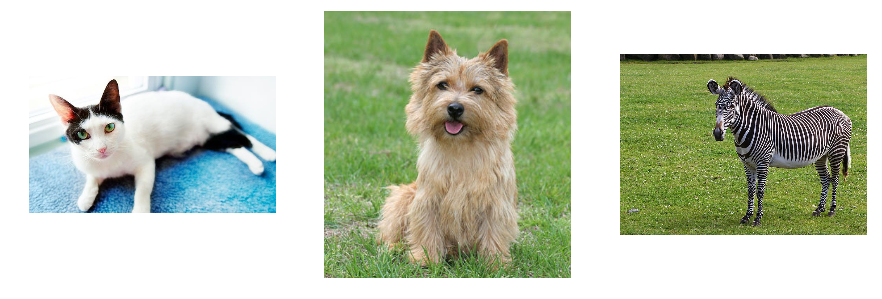

In [3]:
#get list of all images
img_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.jpeg') ]

#load all images
imgs = []
for f in img_files:
    imgs.append(cv2.imread(f))
    
#plot images
fig = plt.figure(figsize=(15,6))
for i, img in enumerate(imgs):
    fig.add_subplot(1,3,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

In [5]:
from alexnet import AlexNet
from caffe_classes import class_names
#placeholder for input and dropout rate
x = tf.placeholder(tf.float32, [1, 227, 227, 3])
keep_prob = tf.placeholder(tf.float32)

#create model with default config ( == no skip_layer and 1000 units in the last layer)
model = AlexNet(x, keep_prob, 1000, [])

#define activation of last layer as score
score = model.fc8

#create op to calculate softmax 
softmax = tf.nn.softmax(score)

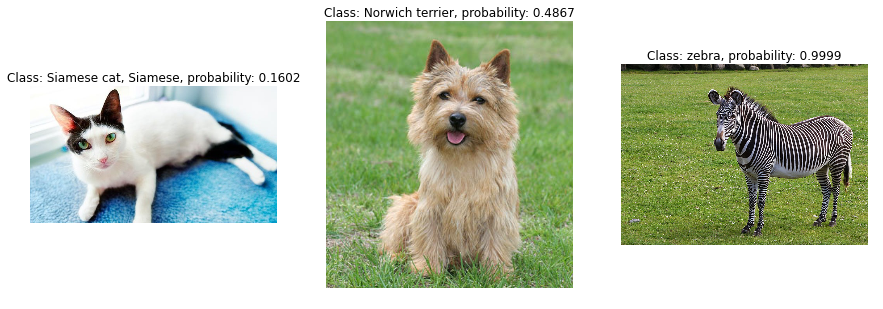

In [6]:
with tf.Session() as sess:
    
    # Initialize all variables
    sess.run(tf.global_variables_initializer())
    
    # Load the pretrained weights into the model
    model.load_initial_weights(sess)
    
    # Create figure handle
    fig2 = plt.figure(figsize=(15,6))
    
    # Loop over all images
    for i, image in enumerate(imgs):
        
        # Convert image to float32 and resize to (227x227)
        img = cv2.resize(image.astype(np.float32), (227,227))
        
        # Subtract the ImageNet mean
        img -= imagenet_mean
        
        # Reshape as needed to feed into model
        img = img.reshape((1,227,227,3))
        
        # Run the session and calculate the class probability
        probs = sess.run(softmax, feed_dict={x: img, keep_prob: 1})
        
        # Get the class name of the class with the highest probability
        class_name = class_names[np.argmax(probs)]
        
        # Plot image with class name and prob in the title
        fig2.add_subplot(1,3,i+1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Class: " + class_name + ", probability: %.4f" %probs[0,np.argmax(probs)])
        plt.axis('off')

<h1>Now comes the fine tuning part..</h1>

In [ ]:
import numpy as np
import tensorflow as tf
from datetime import datetime
from alexnet import AlexNet
from datagenerator import ImageDataGenerator
import os

train_file = '/Users/rahulchandran/rahul/learn/machine_learning/tensorflow/out_of_syllabus/Finetuning_tuts/test/train.txt'
val_file = '/Users/rahulchandran/rahul/learn/machine_learning/tensorflow/out_of_syllabus/Finetuning_tuts/test/valid.txt'

# Learning params
learning_rate = 0.001
num_epochs = 10
batch_size = 128


# Network params
dropout_rate = 0.5
num_classes = 2
train_layers = ['fc8', 'fc7']

# How often we want to write the tf.summary data to disk
display_step = 1

# Path for tf.summary.FileWriter and to store model checkpoints
filewriter_path = "/tmp/finetune_alexnet/dogs_vs_cats"
checkpoint_path = "/tmp/finetune_alexnet/"
if not os.path.isdir(checkpoint_path): 
    os.mkdir(checkpoint_path)
    
# TF placeholder for graph input and output
x = tf.placeholder(tf.float32, [batch_size, 227, 227, 3])
y = tf.placeholder(tf.float32, [None, num_classes])
keep_prob = tf.placeholder(tf.float32)

#initialize model
model = AlexNet(x, keep_prob, num_classes, train_layers)

# Link variable to model output
score = model.fc8

# List of trainable variables of the layers we want to train
var_list = [v for v in tf.trainable_variables() if v.name.split('/')[0] in train_layers]

# Op for calculating the loss
with tf.name_scope("cross_ent"):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = score, labels = y))  


with tf.name_scope("train"):
    # create a symbolic derivative of partial derivatives of the sum od loss w.r.t var_list
    gradients=tf.gradients(loss,var_list)
    gradients=list(zip(gradients,var_list))
    
    # Create optimizer and apply gradient descent to the trainable variables
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_op = optimizer.apply_gradients(grads_and_vars=gradients)
    
#Add grads also to tensorboard summary 
for gradient, var in gradients:
    tf.summary.histogram(var.name + '/gradient', gradient)
    
# Add the variables we train to the summary
for var in var_list:
    tf.summary.histogram(var.name, var)

# Add the loss to summary
tf.summary.scalar('cross_entropy', loss)


# Evaluation op: Accuracy of the model
with tf.name_scope("accuracy"):
    correct_pred = tf.equal(tf.argmax(score, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Add the accuracy to the summary
tf.summary.scalar('accuracy', accuracy)

# Now we'll merge all the summaries together and then write to TB- Filewriter


merged_summary = tf.summary.merge_all()

# Initialize the FileWriter
writer = tf.summary.FileWriter(filewriter_path)

# Initialize a saver for store model checkpoints
saver = tf.train.Saver()

# Crappy Data-augmentation, but still, something is better than nothing..;) 
train_generator = ImageDataGenerator(train_file, 
                                     horizontal_flip = True, shuffle = True)
val_generator = ImageDataGenerator(val_file, shuffle = False) 

# Get the number of training/validation steps per epoch
train_batches_per_epoch = np.floor(train_generator.data_size / batch_size).astype(np.int16)
val_batches_per_epoch = np.floor(val_generator.data_size / batch_size).astype(np.int16)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Add the model graph to TensorBoard
    writer.add_graph(sess.graph)
    
    # Load the pretrained weights into the non-trainable layer
    model.load_initial_weights(sess)

    print("{} Start training...".format(datetime.now()))
    print("{} Open Tensorboard at --logdir {}".format(datetime.now(),filewriter_path))
    
    for epoch in range(num_epochs):
        print("{} Epoch number: {}".format(datetime.now(), epoch+1))
        step = 1
        while step < train_batches_per_epoch:
            # Get a batch of images and labels
            batch_xs, batch_ys = train_generator.next_batch(batch_size)
            
            # And run the training op
            sess.run(train_op, feed_dict={x: batch_xs,y: batch_ys,keep_prob: dropout_rate})
            
            # Generate summary with the current batch of data and write to file
            if step%display_step == 0:
                s = sess.run(merged_summary, feed_dict={x: batch_xs,y: batch_ys,keep_prob: 1.})
                writer.add_summary(s, epoch*train_batches_per_epoch + step)
            step += 1
            
        # Validate the model on the entire validation set
        print("{} Start validation".format(datetime.now()))
        test_acc = 0.
        test_count = 0
        for _ in range(val_batches_per_epoch):
            batch_tx, batch_ty = val_generator.next_batch(batch_size)
            acc = sess.run(accuracy, feed_dict={x: batch_tx, y: batch_ty, keep_prob: 1.})
            test_acc += acc
            test_count += 1
        test_acc /= test_count
        print("{} Validation Accuracy = {:.4f}".format(datetime.now(), test_acc))
        
        
        # Reset the file pointer of the image data generator
        val_generator.reset_pointer()
        train_generator.reset_pointer()
        
        print("{} Saving checkpoint of model...".format(datetime.now()))  
        
        #save checkpoint of the model
        checkpoint_name = os.path.join(checkpoint_path, 'model_epoch'+str(epoch+1)+'.ckpt')
        save_path = saver.save(sess, checkpoint_name) 
        print("{} Model checkpoint saved at {}".format(datetime.now(), checkpoint_name))
            

INFO:tensorflow:Summary name fc7/weights:0/gradient is illegal; using fc7/weights_0/gradient instead.
INFO:tensorflow:Summary name fc7/biases:0/gradient is illegal; using fc7/biases_0/gradient instead.
INFO:tensorflow:Summary name fc8/weights:0/gradient is illegal; using fc8/weights_0/gradient instead.
INFO:tensorflow:Summary name fc8/biases:0/gradient is illegal; using fc8/biases_0/gradient instead.
INFO:tensorflow:Summary name fc7/weights:0 is illegal; using fc7/weights_0 instead.
INFO:tensorflow:Summary name fc7/biases:0 is illegal; using fc7/biases_0 instead.
INFO:tensorflow:Summary name fc8/weights:0 is illegal; using fc8/weights_0 instead.
INFO:tensorflow:Summary name fc8/biases:0 is illegal; using fc8/biases_0 instead.
2017-07-18 14:45:05.497399 Start training...
2017-07-18 14:45:05.497556 Open Tensorboard at --logdir /tmp/finetune_alexnet/dogs_vs_cats
2017-07-18 14:45:05.497639 Epoch number: 1
2017-07-18 15:31:56.128554 Start validation
2017-07-18 15:35:08.838358 Validation Acc

In [4]:
from datagenerator import ImageDataGenerator
train_file = '/Users/rahulchandran/rahul/learn/machine_learning/tensorflow/out_of_syllabus/Finetuning_tuts/test/train.txt'
val_file = '/Users/rahulchandran/rahul/learn/machine_learning/tensorflow/out_of_syllabus/Finetuning_tuts/test/valid.txt'
train_generator = ImageDataGenerator(train_file,horizontal_flip = True, shuffle = True)



AttributeError: 'list' object has no attribute 'copy'